In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

import re

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
import warnings; warnings.simplefilter('ignore')

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import GradientBoostingClassifier

In [2]:
#pip install sklearn
# pip install torch torchvision
# pip install transformers==4.15.0
# pip install sentence-transformers
# pip install ipywidgets

In [3]:
# Read the data
classified_data = pd.read_csv("final_data.csv",  sep=';')
# Clean data
classified_data.replace([np.inf, -np.inf], np.nan, inplace=True)
classified_data = classified_data.dropna()
classified_data.avis1 = classified_data.avis1.astype(int)

In [4]:
classified_data

,avis1,text,id
0,1,Elle ne devait pas dégager la nazi ??? https:/...,1.466478e+18
1,0,je dois faire un oral en anglais sur Hitler et...,1.466478e+18
2,0,@ambrassmoi_ A ça 🤏 de ressembler à la croix n...,1.466478e+18
3,0,"Par curiosité, j’ai voulu écouter les discours...",1.466478e+18
4,1,@tical10 @ExBarcaFan74523 @ConflitsFrance Mdr ...,1.466478e+18
...,...,...,...
2851,1,Kevin c’est un sal noir.,1.464411e+18
2852,1,"bougnoule bamboula sale arabe , elle est belle...",1.464364e+18
2853,1,@B_mahrezz Tu viens de le traiter de sal noir ?,1.464234e+18
2854,1,SAL NOIR https://t.co/JraABFtel8,1.463961e+18


In [5]:
classified_data['avis1'].value_counts()

0    1851
1    1005
Name: avis1, dtype: int64

**CLEAN DATA**

In [6]:
# all the tweets
text = list(classified_data['text'])

In [7]:
import nltk
from  nltk.stem.snowball import FrenchStemmer

def generate_stopwords():
    stopwords_fr = nltk.corpus.stopwords.words("french")
    stop_words = stopwords_fr
    other_exclusions = ["les"]
    stop_words.extend(other_exclusions)
    return stop_words

In [8]:
stopwords = generate_stopwords()

In [9]:
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)

In [10]:
def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+"," ",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", " ", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = tweet.replace("#", " ").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = re.sub(r'[^\w\s]',' ',tweet)
    final_tweet = emoji_pattern.sub(r'', tweet) #Remove all emojis
    return final_tweet

In [11]:
# Apply function cleaner to list of string (text)
map_object = map(cleaner, text)
cleaned_text = list(map_object)
final_text = list(map(lambda x: x.lower(), cleaned_text))

In [12]:
final_df = pd.DataFrame(final_text, columns=["Cleaned Tweets"])
classements = classified_data['avis1']
final_df['Classement'] = classements
final_df

,Cleaned Tweets,Classement
0,elle ne devait pas dégager la nazi,1
1,je dois faire un oral en anglais sur hitler et...,0
2,a ça de ressembler à la croix nazi mdrr,0
3,par curiosité j ai voulu écouter les discours...,0
4,mdr deux nazi n importe quoi,1
...,...,...
2851,kevin c est un sal noir,1
2852,bougnoule bamboula sale arabe elle est belle...,1
2853,mahrezz tu viens de le traiter de sal noir,1
2854,sal noir,1


**EMBEDDING WITH BERT**

Import

In [14]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')

In [15]:
sentence_embeddings = model.encode(final_text)

In [16]:
sentence_embeddings.shape

(2856, 512)

In [18]:
# x_train + x_test
bert_df = pd.DataFrame(sentence_embeddings)
bert_df

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,-0.042616,0.012943,0.020557,-0.028893,0.034665,-0.101931,-0.040627,0.054653,-0.069599,0.078870,...,-0.044723,0.008037,0.068910,0.012170,-0.037566,0.056931,0.003984,0.031599,0.081129,0.003851
1,-0.030887,-0.001331,0.039454,0.020994,0.005853,-0.087681,-0.023335,0.049148,-0.070212,0.030748,...,0.143527,-0.041376,0.040808,-0.008012,-0.016435,0.039760,0.003118,-0.034070,0.049462,-0.033703
2,-0.060275,-0.073298,0.075299,-0.011707,0.010154,-0.028689,-0.043771,-0.021325,-0.014981,0.044133,...,0.005981,0.074229,0.110397,-0.027463,-0.031761,0.013268,0.007706,0.005575,-0.013301,0.024982
3,-0.027122,0.018830,-0.010214,-0.044039,0.071857,-0.055521,0.079057,-0.003731,-0.072494,-0.013171,...,0.049584,0.036237,0.012429,0.012895,-0.024021,-0.030838,-0.033537,-0.014998,0.046951,-0.065068
4,-0.003035,-0.039303,0.013812,-0.057624,0.018102,-0.092746,-0.035957,-0.038816,-0.048145,-0.065571,...,0.038624,0.083552,0.099662,-0.007730,-0.023716,0.015990,-0.000095,-0.008739,0.060285,-0.027889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851,0.022852,0.027432,0.038667,-0.013879,0.005034,0.005344,-0.040401,-0.014044,0.054095,0.036961,...,-0.000091,-0.046505,0.054838,-0.033437,-0.048649,0.058183,0.006658,-0.027120,-0.006456,0.025710
2852,-0.007075,0.038605,0.037965,-0.015389,0.045865,-0.059956,-0.014563,0.001013,0.053555,0.057164,...,0.011677,0.001502,-0.004908,-0.019449,0.020760,0.042417,0.062798,-0.026114,0.052585,-0.010385
2853,0.021322,0.012744,0.005795,0.022634,0.009331,-0.080154,-0.005330,0.008400,0.055304,0.026841,...,0.047865,0.017698,0.030809,-0.036504,-0.020777,0.048206,-0.029109,-0.007326,0.066231,-0.001880
2854,0.027365,0.046461,-0.008071,-0.013620,-0.023218,-0.039475,0.011383,-0.010844,0.018849,-0.013087,...,0.055492,-0.009762,0.005501,-0.014515,-0.043474,0.002562,-0.031522,-0.023956,0.090468,-0.007074


In [19]:
# Split Data to train and test parts
y = final_df["Classement"]
X_train, X_test, y_train, y_test = train_test_split(bert_df, y, test_size=0.2, random_state=42)

## Random Forest

In [20]:
random_forest_model = RandomForestClassifier()
random_forest_model.fit(X_train, y_train)

RandomForestClassifier()

In [21]:
y_pred = random_forest_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred))

Accuracy: 0.7587412587412588


In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.94      0.84       375
           1       0.78      0.42      0.55       197

    accuracy                           0.76       572
   macro avg       0.77      0.68      0.69       572
weighted avg       0.76      0.76      0.74       572



In [23]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred).ravel())
# TN FP FN TP

Confusion Matrix:
[351  24 114  83]


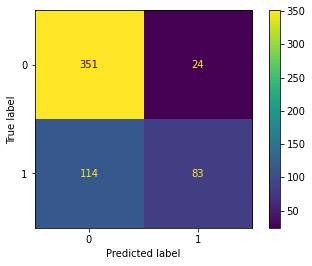

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(random_forest_model, X_test, y_test)

## Logistic Regression

In [25]:
logistic_regression_model = LogisticRegression().fit(X_train, y_train)

In [26]:
y_pred_LR = logistic_regression_model.predict(X_test)
logistic_regression_model.score(X_test, y_test)

0.777972027972028

In [27]:
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       375
           1       0.73      0.56      0.64       197

    accuracy                           0.78       572
   macro avg       0.76      0.73      0.74       572
weighted avg       0.77      0.78      0.77       572



In [28]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_LR).ravel())

Confusion Matrix:
[334  41  86 111]


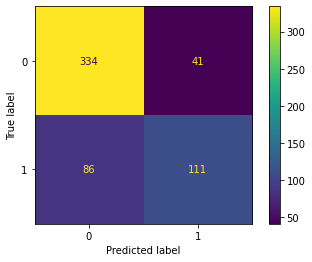

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logistic_regression_model, X_test, y_test)

## XGBOOST

In [30]:
xgboost_model = GradientBoostingClassifier().fit(X_train, y_train)

In [31]:
y_pred = xgboost_model.predict(X_test)
xgboost_model.score(X_test, y_test)

0.7622377622377622

In [32]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.83       375
           1       0.72      0.51      0.60       197

    accuracy                           0.76       572
   macro avg       0.75      0.70      0.71       572
weighted avg       0.76      0.76      0.75       572



In [33]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred).ravel())

Confusion Matrix:
[336  39  97 100]


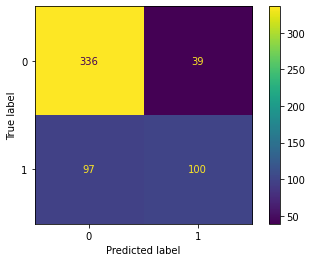

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(xgboost_model, X_test, y_test)